# Image Segmentation
Applying semantic face sementation on CelebMask-HQ. The full code can be cloned from the given URL - https://github.com/Sanjana7395/face_segmentation.git

In [1]:
# Import required packages
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Input
%load_ext tensorboard
from preprocessing import augment_dataset
import test
from model import u_net
import train

/home/pavan/venv/segmentation/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pavan/venv/segmentation/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pavan/venv/segmentation/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pavan/venv/segmentation/lib/python3.6/site-packages/ten

In [2]:
def display(display_list, result):
    """ Display a row of given images

    :param display_list: list of images to display
    :type display_list: list of str
    :param result: filename in which the plot is saved in results folder
    :type result: str

    """
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


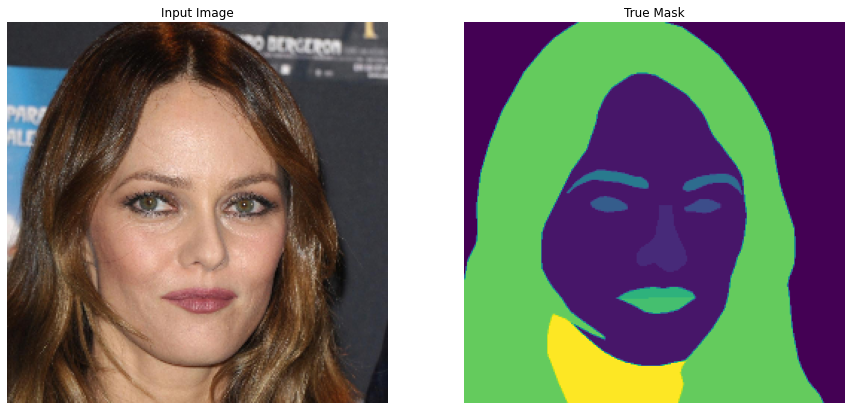

In [3]:
# Display sample image and the corresponding segmentation mask
test_data = augment_dataset.get_test()
for img, label in test_data.take(1):
    sample_image, sample_mask = img[2], label[2]
    display([sample_image, sample_mask], 'test_sample')

In [4]:
# Load test data as numpy array
images = np.load('../data/test_images.npy')
masks = np.load('../data/test_mask.npy')

## Model - UNet

In [5]:
input_img = Input(shape=(256, 256, 3), name='img')
model = u_net.get_u_net(input_img, num_classes=19)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
trainer = train.Train()
trainer.train('unet')

In [ ]:
%tensorboard --logdir ../logs/fit

In [6]:
model.load_weights('../results/models/u_net.h5')

In [7]:
color_list = [[0, 0, 0], [204, 0, 0], [255, 140, 26], [204, 204, 0],
              [51, 51, 255], [204, 0, 204], [0, 255, 255],
              [255, 204, 204], [102, 51, 0], [255, 0, 0],
              [102, 204, 0], [255, 255, 0], [0, 0, 153], [0, 0, 204],
              [255, 51, 153], [0, 204, 204], [0, 51, 0], [255, 153, 51], [0, 204, 0]]
def plot_mask(prediction, mask, image):
    """ PLot segmentation mask as overlay on the given image.

    :param prediction: predicted output of the model.
    :type prediction: array
    :param mask: true masks of the images.
    :type mask: array
    :param image: original image.
    :type image: array

    """
    im_base = np.zeros((256, 256, 3), dtype='float32')
    for idx, color in enumerate(color_list):
        im_base[prediction == idx] = color
    cv2.addWeighted(im_base, 0.1, image, 0.9, 0, im_base)
    display([image, mask, im_base], 'predict')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


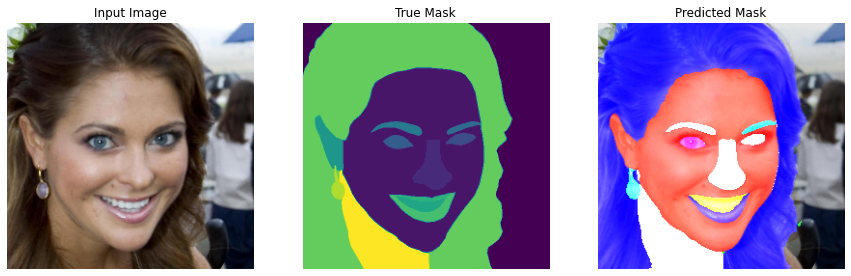

In [8]:
# Predict segmentation for given images
predictions = model.predict(images)
predictions = np.argmax(predictions, axis=-1)
plot_mask(predictions[4], masks[4], images[4])